Group 8 Project 

In [1]:
library(tidyverse)
library(repr)
library(datateachr)
library(infer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# This data frame contains crime data from the year 2003 to 2023 for a multitude of different neighborboods
all_crime <- read.csv("crimedata_csv_AllNeighbourhoods_AllYears.csv")
head(all_crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


In [3]:
# This reduced data set contains only break and enter type crime during the year of 2022
# There are originally commercial and residential/other types of break and enter, but this gets generalized to 'Break and Enter' for simplicity
crime <- all_crime %>%
    filter(YEAR == 2022) %>%
    select(TYPE, NEIGHBOURHOOD) 
crime$TYPE <- replace(crime$TYPE, crime$TYPE == 'Break and Enter Commercial', 'Break and Enter')
crime$TYPE <- replace(crime$TYPE, crime$TYPE == 'Break and Enter Residential/Other', 'Break and Enter')
head(crime)

,TYPE,NEIGHBOURHOOD
,<chr>,<chr>
1,Break and Enter,West End
2,Break and Enter,West End
3,Break and Enter,West End
4,Break and Enter,West End
5,Break and Enter,West End
6,Break and Enter,Shaughnessy


The following cell calculates the proportion of break and enters for each Vancouver Neighbourhood and plots this information on a bar graph.  

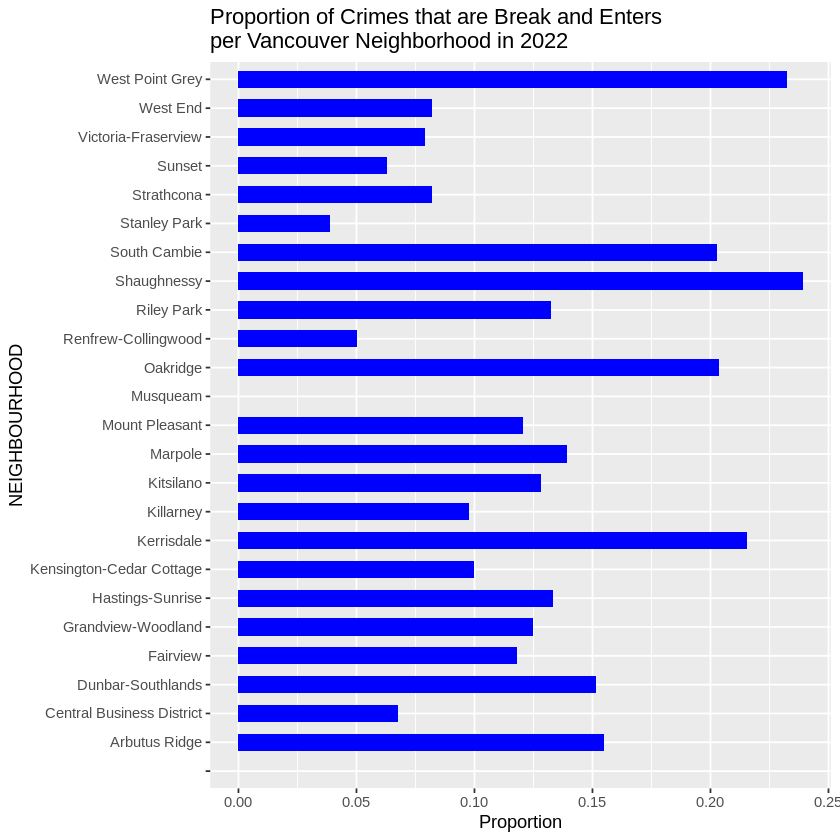

In [4]:
prop_bne <- crime %>%
    group_by(NEIGHBOURHOOD) %>%
    mutate(num = sum(TYPE == 'Break and Enter')) %>%
    mutate(prop = num / n()) %>%
    select(NEIGHBOURHOOD, prop) %>%
    distinct() 

plot_prop_bne <- prop_bne %>%
    ggplot() +
    geom_col(aes(prop, NEIGHBOURHOOD), fill = 'blue', width = 0.6) +
    labs(x = 'Proportion', title = 'Proportion of Crimes that are Break and Enters \nper Vancouver Neighborhood in 2022')

plot_prop_bne

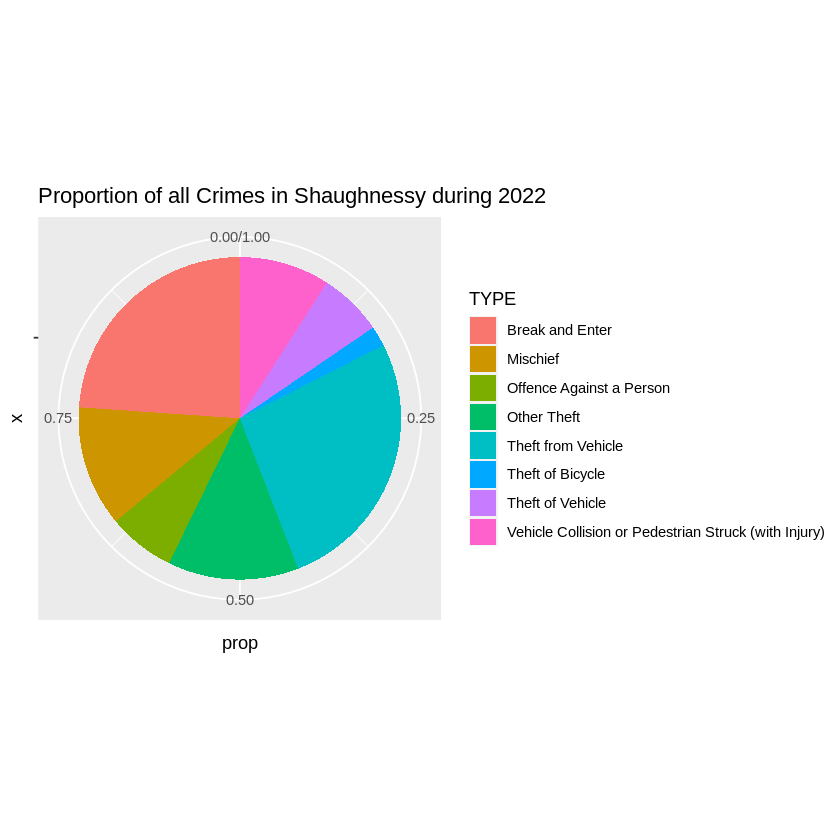

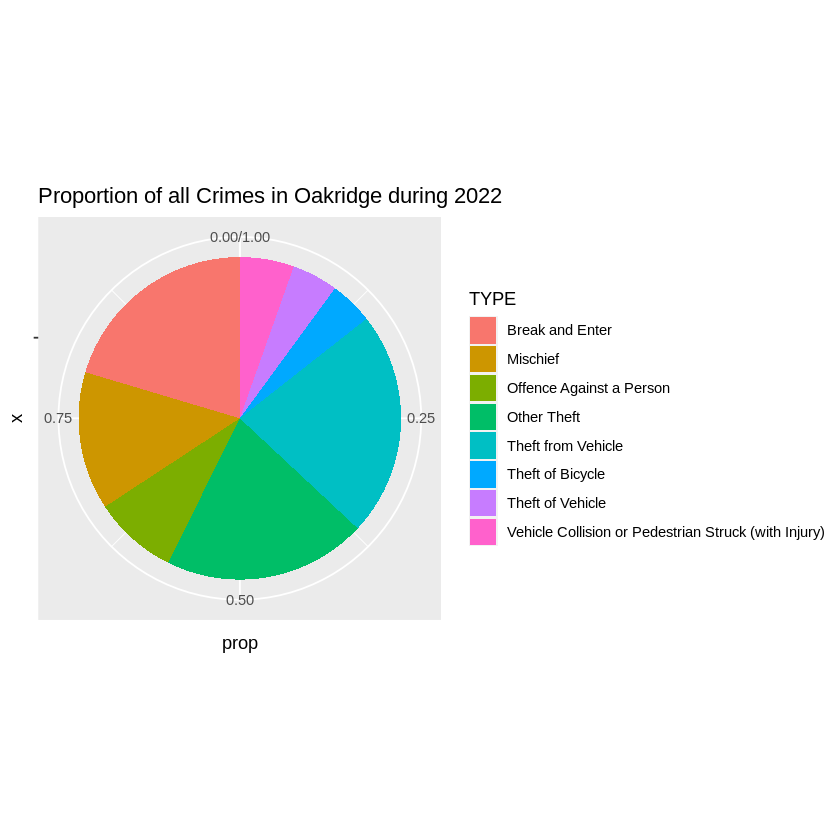

In [5]:
# total number of crimes in this neighbourhood
total_crime_shaughnessy <- crime %>%
    summarize(sum = sum(NEIGHBOURHOOD == 'Shaughnessy')) %>%
    pull()

total_crime_oakridge <- crime %>%
    summarize(sum = sum(NEIGHBOURHOOD == 'Oakridge')) %>%
    pull()

crime_shaughnessy <- crime %>%
    filter(NEIGHBOURHOOD == 'Shaughnessy') %>%
    group_by(TYPE) %>%
    summarize(prop = n() / total_crime_shaughnessy) 

crime_oakridge <- crime %>%
    filter(NEIGHBOURHOOD == 'Oakridge') %>%
    group_by(TYPE) %>%
    summarize(prop = n() / total_crime_oakridge) 

plot_crime_type_shaughnessy <- crime_shaughnessy %>%
    ggplot(aes(x="", y=prop, fill=TYPE)) +
    geom_bar(stat="identity", width=1) +
    coord_polar("y", start=0) +
    labs(title = 'Proportion of all Crimes in Shaughnessy during 2022')

plot_crime_type_oakridge <- crime_oakridge %>%
    ggplot(aes(x="", y=prop, fill=TYPE)) +
    geom_bar(stat="identity", width=1) +
    coord_polar("y", start=0) +
    labs(title = 'Proportion of all Crimes in Oakridge during 2022')

plot_crime_type_shaughnessy
plot_crime_type_oakridge

The following cell produces the silulation-based null distribution of the difference in proportion of break and enters between our two chosen neighbourhoods by using 2000 resamples with replacement. This is aproximating what the sampling variation would be in a world where there is no difference in the proportions of break and enters between the two neighbourhoods. The vertical red line is the observed test statistic calculated from our 2022 sample. The shaded red region indicates the how often the null test was even more pronounced than the observed test statistic. 

p_value
<dbl>
0.1695


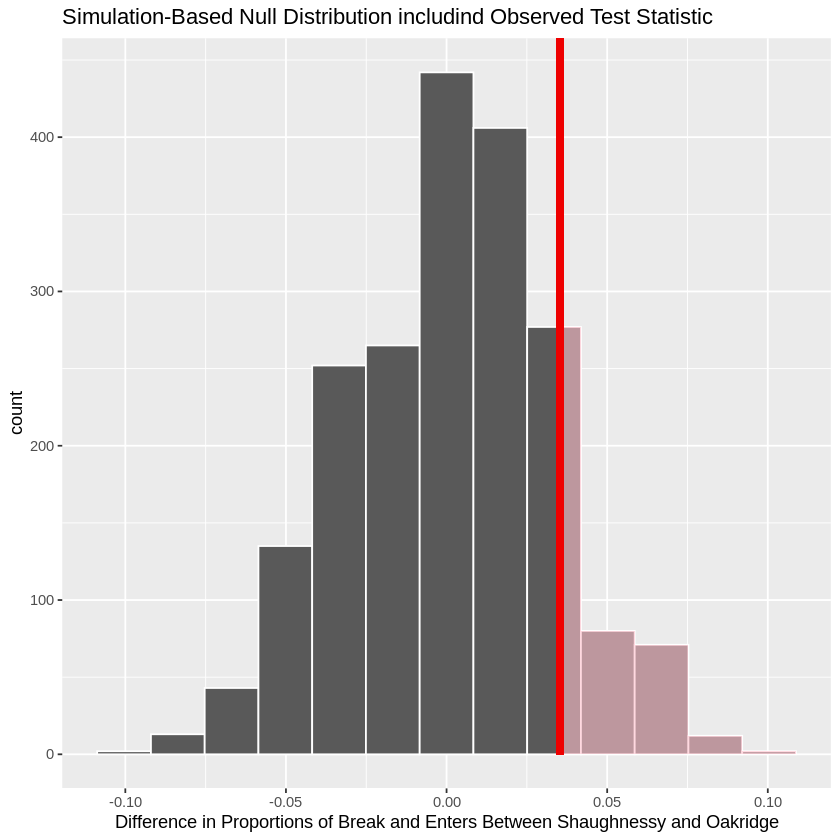

In [6]:
set.seed(222)
# Now for the actual confidence interval
crime_two_nh <- crime %>%
    filter(NEIGHBOURHOOD %in% c('Shaughnessy', 'Oakridge'))

# the infer package 'success'can only be used if the response variable only has two levels
# This line replaces all the other types of crime besides 'Break and Enter' to be 'Other Crimes'
crime_two_nh$TYPE <- replace(crime_two_nh$TYPE, crime_two_nh$TYPE != 'Break and Enter', 'Other Crimes')

# The actual observed difference in proportions of our sample
obs_diff_props <- crime_two_nh %>%
    specify(TYPE ~ NEIGHBOURHOOD, success = 'Break and Enter') %>%
    calculate(stat = 'diff in props', order = c('Shaughnessy', 'Oakridge'))

null_distribution <- crime_two_nh %>%
    specify(TYPE ~ NEIGHBOURHOOD, success = 'Break and Enter') %>%
    hypothesise(null = 'independence') %>%
    generate(reps = 2000, type = 'permute') %>%
    calculate(stat = 'diff in props', order = c('Shaughnessy', 'Oakridge'))
        
visualize(null_distribution, bins = 13) +
    shade_p_value(obs_stat = obs_diff_props, direction = 'right') +
    labs(title = 'Simulation-Based Null Distribution includind Observed Test Statistic', 
         x = 'Difference in Proportions of Break and Enters Between Shaughnessy and Oakridge')

p_value <- null_distribution %>%
    get_p_value(obs_stat = obs_diff_props, direction = 'right')
p_value

The simulation-based confidence interval is generated using 2000 resamples with replacement. A confidence interval of 95% was obtained and plotted on the histogram. Given this simulation, we are 95% confident that the true difference in proportions of break and enter crimes between Shaughnessy and Oakridge lies between the lower and upper bounds of the confidence interval. 

Given this simulation, we are 95% confident that the true difference in proportions of break and enter 
crimes between Shaughnessy and Oakridge lies between  -0.03  and  0.102

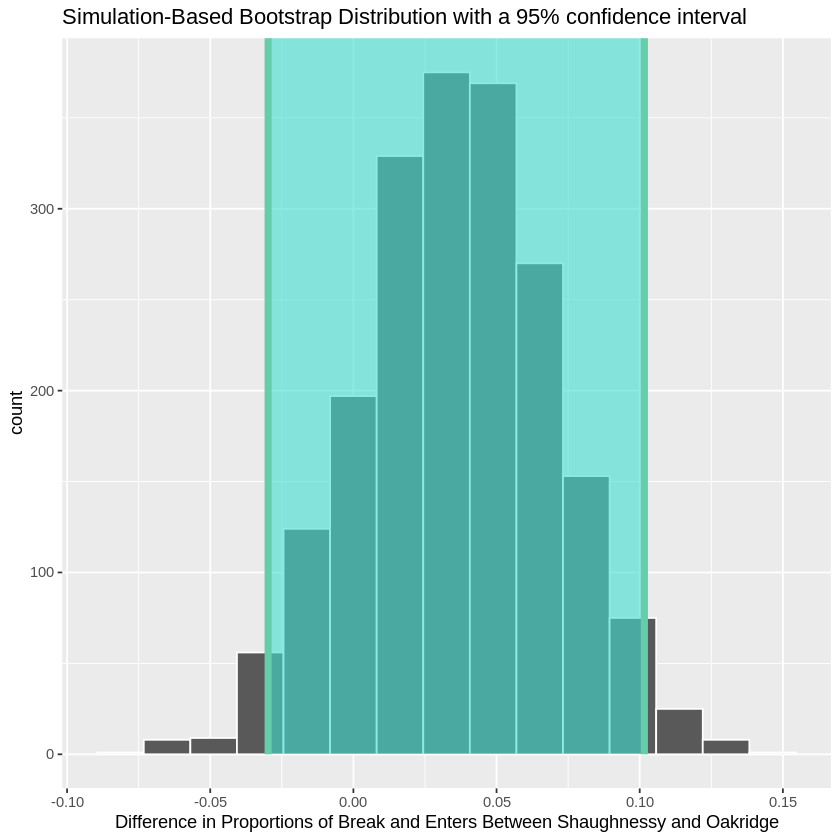

In [17]:
bootstrap_distribution <- crime_two_nh %>%
    specify(TYPE ~ NEIGHBOURHOOD, success = 'Break and Enter') %>%
    generate(reps = 2000, type = 'bootstrap') %>%
    calculate(stat = 'diff in props', order = c('Shaughnessy', 'Oakridge'))

percentile_ci <- bootstrap_distribution %>%
    get_ci(level = 0.95, type = 'percentile')

visualize(bootstrap_distribution) +
    shade_confidence_interval(endpoints = percentile_ci) +
    labs(title = 'Simulation-Based Bootstrap Distribution with a 95% confidence interval', 
         x = 'Difference in Proportions of Break and Enters Between Shaughnessy and Oakridge')

cat('Given this simulation, we are 95% confident that the true difference in proportions of break and enter \ncrimes between Shaughnessy and Oakridge lies between ',round(percentile_ci[[1]],3),' and ',round(percentile_ci[[2]],3)) 

In the next section, we will be producing a confidence interval by using the Central Limit Theorem. In order to use this theoretical method, several conditions need to be met by our data. The sample must be big enough, the sample must have been taken in an independent fashion, and the estimator being used needs to be a sum of random components. As indicated below, there are 665 observations in the data set; therefore, it is large enough. This data was extracted from the PRIME BC Police Records Management System (RMS), which indicates that it was likely gathered in an independent fashion. Lastly, the estimator being used is the difference in proportions, which is indeed a sum of random components. 

In [20]:
cat('The number of observations in this data set is: ',nrow(crime_two_nh))

The number of observations in this data set is:  665

In [37]:
# we calculated the point estimate in an earlier section:
p_hat <- obs_diff_props[[1]]

theoretical_ci <- 
    mutate(n = 665, # number of observations 
           SE = sqrt(p_hat * (1 - p_hat) / n), #standard error
           MoE = 1.96 * SE) %>% # margine of error 
           # lower_ci = p_hat - MoE,
           # upper_ci = p_hat + MoE) %>%
    summarize(lower_ci = p_hat - MoE,
              upper_ci = p_hat + MoE)
theoretical_ci

ERROR: Error in UseMethod("mutate"): no applicable method for 'mutate' applied to an object of class "c('double', 'numeric')"
